The objectives of this notebook are two-fold:
1. To reproduce the plots shown in [this](https://www.youtube.com/watch?v=eUWlzAQfgFw&list=PLgCR5H4IzggHyHw8dalrVHqHAqZfmTeWa&index=15) video in Julia.
2. Define *recipies* for said plots.

## The Danish Dataset

We'll use the [Danish Fire Insurance Claims](http://vincentarelbundock.github.io/Rdatasets/datasets.html) dataset as Dr Cirrillo does, so that we can compare results. First we have to load it up. First column is the row number so we can ignore that. Second column is the claim amount. Not sure what the currency (1000s of Kr would be my guess) is but it doesn't really matter for this example. 

In [1]:
using CSV
dataset = CSV.read("danish.csv")[:,2];

As Dr Cirillo says, the first thing is to get to know the data. We can look at the simplest statistics and start to get an idea of what we have. 2167 data points. Median less than mean indicating a skew to left, etc.

In [2]:
using StatsBase
describe(dataset)

Summary Stats:
Length:         2167
Missing Count:  0
Mean:           3.385088
Minimum:        1.000000
1st Quartile:   1.321119
Median:         1.778154
3rd Quartile:   2.967023
Maximum:        263.250366
Type:           Float64


A histogram of the data shows the spread. There is immediately a whiff of a tail.

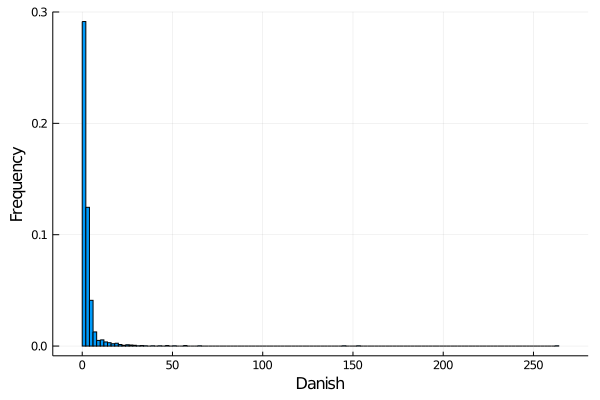

In [3]:
ENV["GKS_ENCODING"]="utf8" # Allow Unicode character in GR
using Plots
histogram(dataset, nbins=200, normed=true, leg=:none, xlabel="Danish", ylabel="Frequency")

## QQ-Plot (or Quantile-Quantile Plot)

This is the first plot from the demo. It compares the spread of the data with another known distribution. In this case the Exponential distribution is our reference and we can see that our data tending upwards which indicates a super-exponential. With the `Distributions` package we can compare to an Exponential distribution easily using the `qqbuild()` function it provides.

In [4]:
using Distributions
@userplot QQPlot

@recipe function f(h::QQPlot)
    x, = h.args
    qqpair = qqbuild(x, Exponential())
    
    legend --> :none
    markerstrokewidth --> 0
    seriestype := :scatter
    tick_direction --> :out

    qqpair.qx, qqpair.qy
end

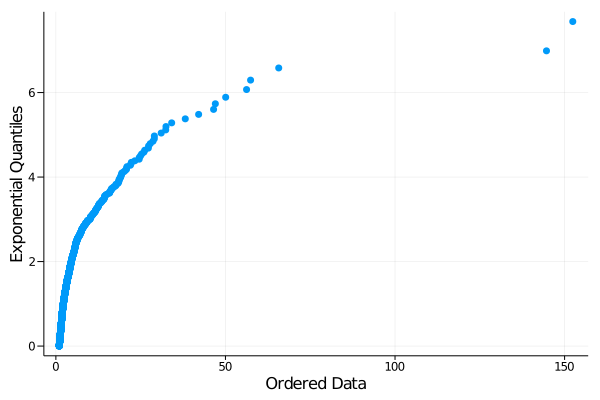

In [5]:
qqplot(dataset, xlabel="Ordered Data", ylabel="Exponential Quantiles")

## Zipf Plot (or Log-Log Plot)

The clasic plot for looking at [power law](https://en.wikipedia.org/wiki/Power_law) behaviour. Shows the survival function for each empirical point on a log-log scale.

We have defined a Plots recipe to set the axis scales and ticks appropriately to give a good looking plot and very similar to the one in the video.

In [6]:
using StatsBase

@userplot Zipf

@recipe function f(h::Zipf)
    x, = h.args
    x = sort(x)
    
    legend --> :none
    markerstrokewidth --> 0
    
    F = ecdf(x)
    y = 1 .- F(x)
    x₋ = 10^floor(log10(minimum(filter(x -> x>0, x))))
    x₊ = maximum(x)
    y₋ = 10^floor(log10(minimum(filter(y -> y>0, y))))

    seriestype := :scatter
    xscale := :log10
    yscale := :log10
    xlims --> (x₋/1.2, x₊*1.2)
    ylims --> (y₋/1.2, 1.0*1.2)
    tick_direction --> :out

    [x;x₊], [y;y₋] # Append upper point

end

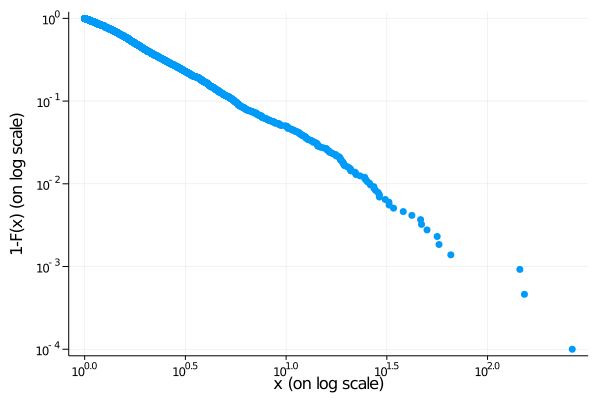

In [7]:
zipf(dataset, xlabel="x (on log scale)", ylabel="1-F(x) (on log scale)")

## Mean Excess Plot

Now we're getting to more exotic plots. This one takes the average of the samples above a certain threshold, the mean excess.

In [8]:
@userplot MEPlot

@recipe function f(h::MEPlot)
    X, = h.args
    X = sort(X)
    maxx = Int(floor(length(X)*0.999)) # Ignore highest noisy values
    
    legend --> :none
    markerstrokewidth --> 0
    
    me = [mean(filter(x -> x > ν, X) .- ν) for ν in X[1:maxx]]
    
    seriestype := :scatter
    tick_direction --> :out

    X[1:maxx], me

end

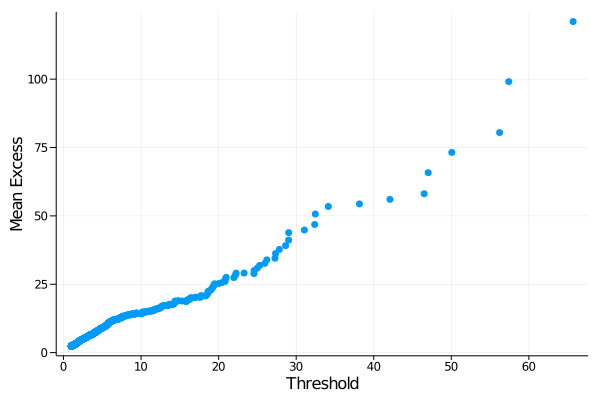

In [9]:
meplot(dataset, ylabel="Mean Excess", xlabel="Threshold")

## Concentration Profile

Even more exotic is the concentration profile which seems to be an [invention of Dr Cirillo](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2850949) himself.

In [10]:
F = ecdf(dataset)
F¯¹(α)=Iterators.first(Iterators.filter(y->F(y)<=α, (x for x in maximum(F):-0.1:minimum(F))))

F¯¹ (generic function with 1 method)

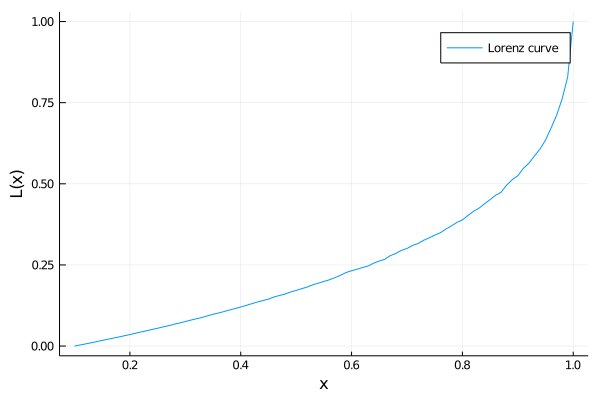

In [33]:
using QuadGK
Z = first(quadgk(F¯¹, 0.1, 1.0, rtol=1e-2))
L(x) = first(quadgk(F¯¹, 0.1, x, rtol=1e-2))/Z
plot(0.1:0.01:1.0, L, label="Lorenz curve", xlabel="x", ylabel="L(x)")

This is a translation a Python implementation described in Dr Cirillo's paper.

In [14]:
@userplot CPPlot

# k = number of right tail observations with which to compute the last order statistics
@recipe function f(h::CPPlot)
    X,k = h.args
    X = sort(X)

    function _gini_index(dataSorted)
        n = length(dataSorted)
        weights = 1:n
        G = 2 * sum(dataSorted .* weights)/sum(dataSorted) - (n + 1)
        G/n
    end

    cp = [_gini_index(X[i:end]) for i in 1:length(X)-k]
    
    legend --> :none
    markerstrokewidth --> 0    
    seriestype := :scatter
    tick_direction --> :out

    cp
end

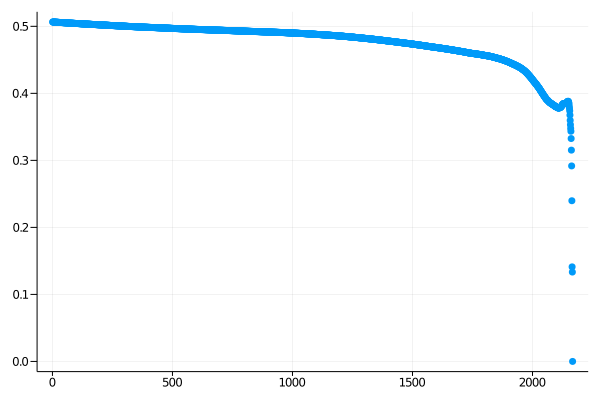

In [15]:
cpplot(dataset, 0)

## MS Plot (Max-Sum Plot)

Slightly simpler plot of the cumulative maximum vs the cumulative sum of the empirical moments of the dataset. We are looking to see which of the moments converge to 0, if any.

In [16]:
@userplot MSPlot

@recipe function f(h::MSPlot)
    x,p = h.args

    ms = x.^p
    maxsum = accumulate(max, ms)./cumsum(ms)
    
    legend --> :none
    tick_direction --> :out
    ylims --> (0,maximum(maxsum))

    maxsum
end

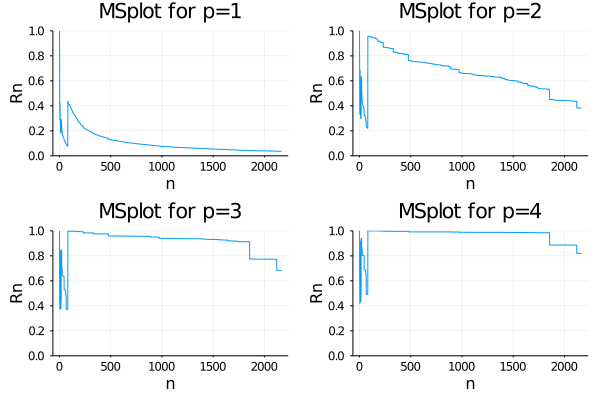

In [17]:
ps = [msplot(dataset, p; title="MSplot for p=$p") for p in 1:4]
plot(ps..., xlabel="n", ylabel="Rn", ylims=(0.0,1.0))

This shows the first moment converging, as expected, but the other moments struggling to doing so.

## Hill Plot

Finally a very nice plot, but what is it? See [here](https://www.rdocumentation.org/packages/evmix/versions/2.12/topics/hillplot).

In [18]:
@userplot HillPlot

@recipe function f(h::HillPlot; kmin = 15)
    x, = h.args
    x = sort(x, rev=true)

    H = [sum([log(x[i]) for i in 1:k])/k - log(x[k+1]) for k in kmin:length(x)-1]
    
    legend --> :none
    tick_direction --> :out
        
    kmin:length(x)-1, 1 ./ H

end

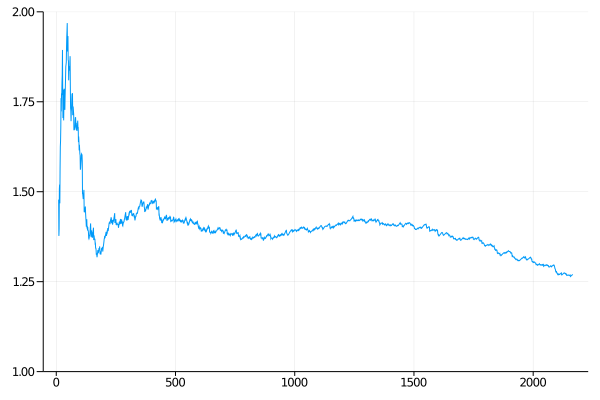

In [19]:
hillplot(dataset, kmin=10, ylims=(1.0,2.0))

TODO: add confidence range to the plot as a ribbon.

# Tails of well-known distributions

In [20]:
N=1000
Xs = [
    ("Normal",rand(Normal(), N)),
    ("Exponential",rand(Exponential(), N)),
    ("LogNormal",rand(LogNormal(), N)),
    ("Pareto",rand(Pareto(), N))
];

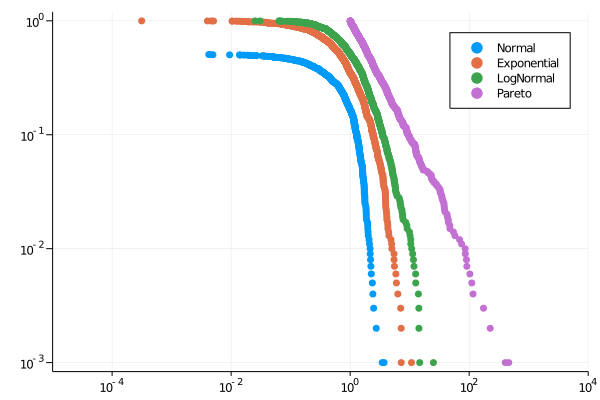

In [21]:
zipf(last(Xs[1]), leg=true, label=first(Xs[1]))
for i in 2:length(Xs)
    zipf!(last(Xs[i]), leg=true, label=first(Xs[i]), xlims=(1e-5, 1e4))
end
plot!()

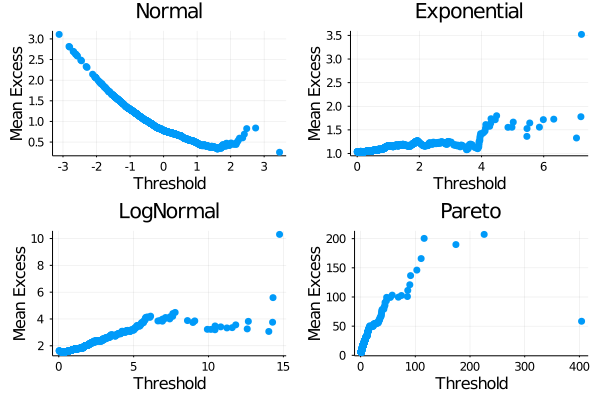

In [22]:
plot(
    [meplot(last(X), title=first(X)) for X in Xs]...,
    ylabel="Mean Excess", xlabel="Threshold"
)

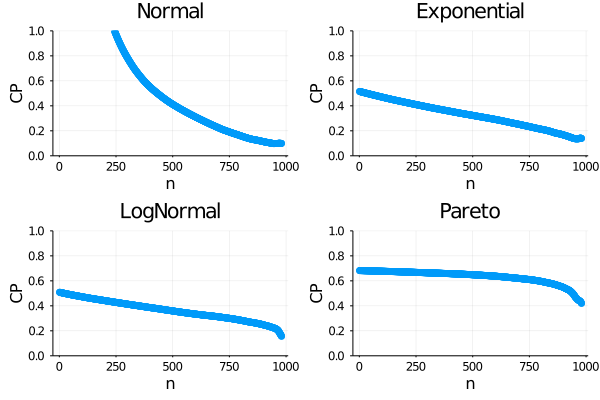

In [23]:
plot(
    [cpplot(last(X), 20, title=first(X)) for X in Xs]...,
    ylabel="CP", xlabel="n", ylims=(0,1)
)

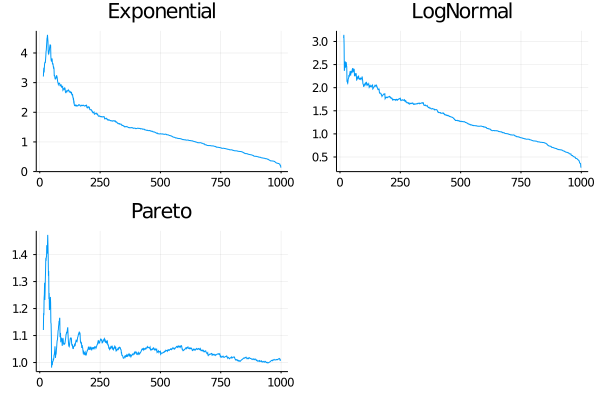

In [24]:
plot(
    [hillplot(last(X), 20, title=first(X)) for X in Xs[2:end]]...
)

In [25]:
α=0.2
trajectories = []
for j in 1:1000
    trajectory = [10.0]
    for i in 1:199
        next = trajectory[i]*(if rand()>0.5 (1-α) else (1+α*1.2) end)
        if next < 0.01 next = 0 end
        push!(trajectory, next)
    end
    push!(trajectories, trajectory)
end

In [26]:
takehome = hcat(trajectories...)[end,:];

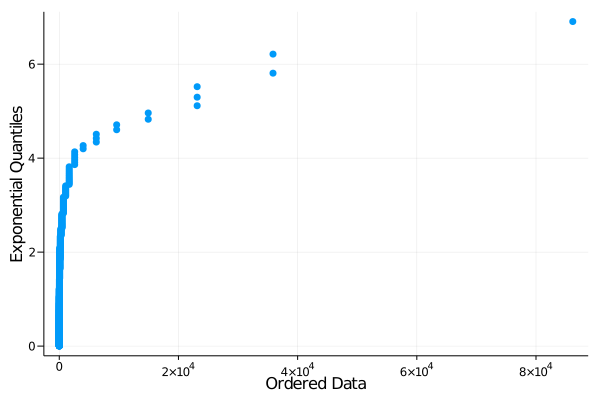

In [27]:
qqplot(takehome, xlabel="Ordered Data", ylabel="Exponential Quantiles")

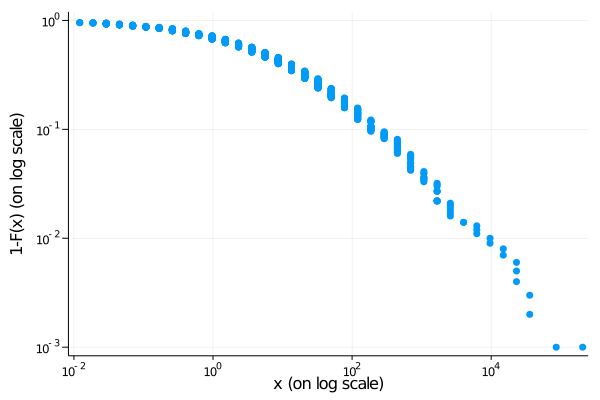

In [28]:
zipf(takehome, xlabel="x (on log scale)", ylabel="1-F(x) (on log scale)")

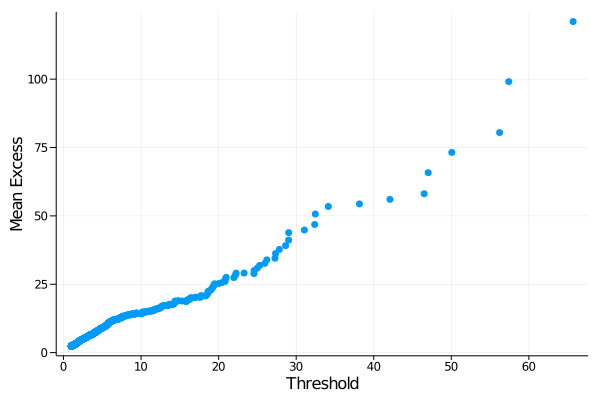

In [29]:
meplot(dataset, ylabel="Mean Excess", xlabel="Threshold")

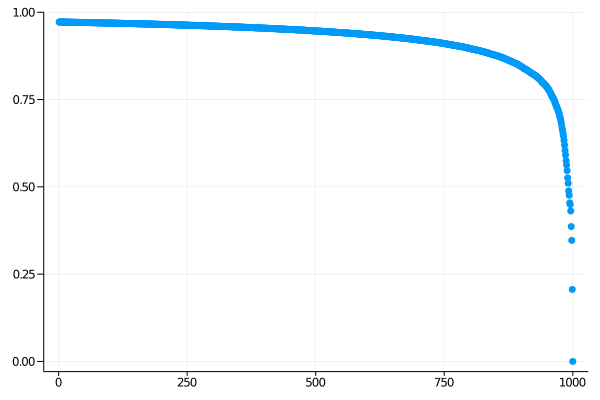

In [30]:
cpplot(takehome, 0)

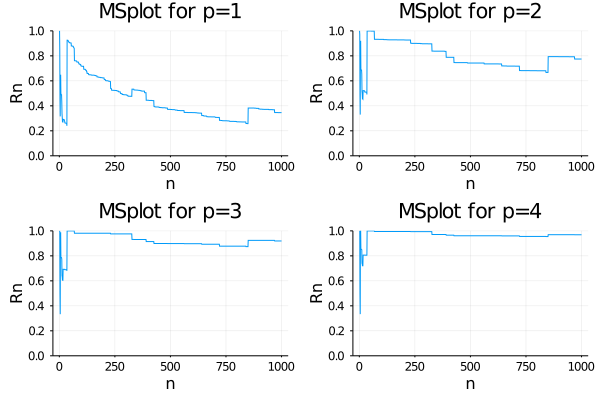

In [31]:
ps = [msplot(takehome, p; title="MSplot for p=$p") for p in 1:4]
plot(ps..., xlabel="n", ylabel="Rn", ylims=(0.0,1.0))

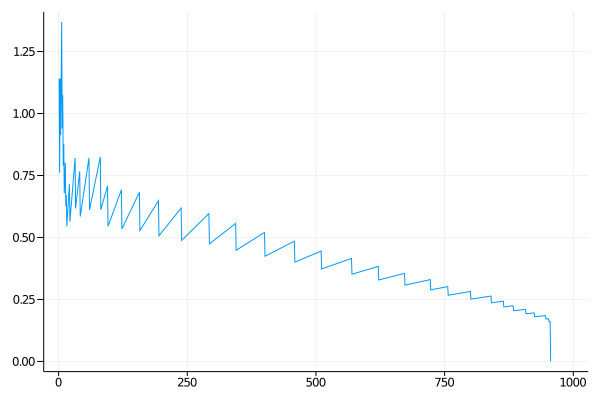

In [32]:
hillplot(takehome, kmin=1)